In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
import torch
import pandas as pd
def read_jsonl(file):
    with open(file, 'r') as f:
        data=[json.loads(line) for line in f]
        print(f'Length of data is {len(data)}')
        return data
def filter_and_replace(value):
    value=value.lower()
    if 'yes' in value:
        return 'yes'
    elif 'no' in value:
        return 'no'
    else:
        return value

def entropy(p_yes, p_no):
    """Calculate the entropy for a given probability."""
    if p_yes <= 0 or p_no <= 0:
        return 0
    p_yes = torch.tensor([p_yes], dtype=torch.float32)
    p_no = torch.tensor([p_no], dtype=torch.float32)
    entropy_value = -p_yes * torch.log2(p_yes) - p_no * torch.log2(p_no)
    return entropy_value.item()




## 读取数据

In [3]:
# obj_data=read_jsonl('/home/ubuntu/hallu_team/junkai/Dataset/RLC-bench/answer/Object/Minigpt4/Object.jsonl')
obj_data=read_jsonl('/home/ubuntu/junkai/RLC-bench/answer/Object/llava-v1.5/llava-v1.5-13b/Object.jsonl')
# #
# #
obj_pd=pd.DataFrame(obj_data)

# rel_data=read_jsonl('/home/ubuntu/hallu_team/junkai/Dataset/RLC-bench/answer/Relation/Minigpt4/Relation.jsonl')
# /home/ubuntu/hallu_team/junkai/Dataset/RLC-bench/answer/Relation/llava-v1.5/llava-v1.5-7b/Relation.jsonl
# rel_data=read_jsonl('/home/ubuntu/junkai/RLC-bench/test/dola_test/YesandNo_13b.jsonl')
# 
# rel_pd=pd.DataFrame(rel_data)


Length of data is 9000


## 处理Object (POPE)数据

In [4]:
obj_pd['entropy'] = obj_pd.apply(lambda row: entropy(row['yes_prob'], row['no_prob']), axis=1)
obj_pd['decision_prob']= obj_pd[['yes_prob', 'no_prob']].max(axis=1)
obj_pd['response']=obj_pd['response'].apply(filter_and_replace)

obj_wrong=obj_pd[obj_pd['response']!=obj_pd['label']]
obj_right=obj_pd[obj_pd['response']==obj_pd['label']]
print(f'Length of wrong object case is {len(obj_wrong)}')
print(f'Length of right object case is {len(obj_right)}')
equal_obj_right = obj_right.sample(n=len(obj_wrong), random_state=1)

print(f'Length of equal object right is {len(equal_obj_right)}')
print(f'Length of total is {len(obj_pd)}')

obj_pd.head()

Length of wrong object case is 1421
Length of right object case is 7579
Length of equal object right is 1421
Length of total is 9000


,image_id,query_prompt,response,label,mllm_name,type,yes_prob,no_prob,entropy,decision_prob
0,COCO_val2014_000000310196,Is there a snowboard in the image?,yes,yes,llava-v1.5-13b,object-YesNo,0.682574,0.317426,0.901561,0.682574
1,COCO_val2014_000000310196,Is there a backpack in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.763484,0.236516,0.789199,0.763484
2,COCO_val2014_000000310196,Is there a person in the image?,yes,yes,llava-v1.5-13b,object-YesNo,0.998755,0.001245,0.013807,0.998755
3,COCO_val2014_000000310196,Is there a car in the image?,no,no,llava-v1.5-13b,object-YesNo,0.020646,0.979354,0.145052,0.979354
4,COCO_val2014_000000310196,Is there a skis in the image?,yes,yes,llava-v1.5-13b,object-YesNo,0.929440,0.070560,0.368008,0.929440


## Object幻觉 对错case的概率分布

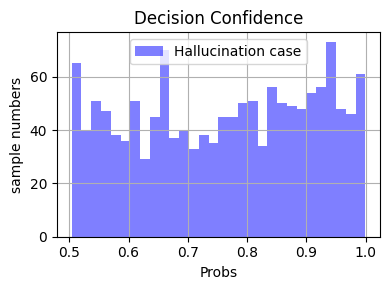

In [6]:
plt.figure(figsize=(4, 3))


# plt.hist(equal_obj_right['decision_prob'], bins=30, alpha=0.5, label='right case', color='red')
plt.hist(obj_wrong['decision_prob'], bins=30, alpha=0.5, label='Hallucination case', color='blue')



plt.xlabel('Probs')
plt.ylabel('sample numbers')
plt.title('Decision Confidence')

plt.legend(loc='upper center')
plt.grid(True)
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 最终放在论文中的img 双图

NameError: name 'equal_rel_right' is not defined

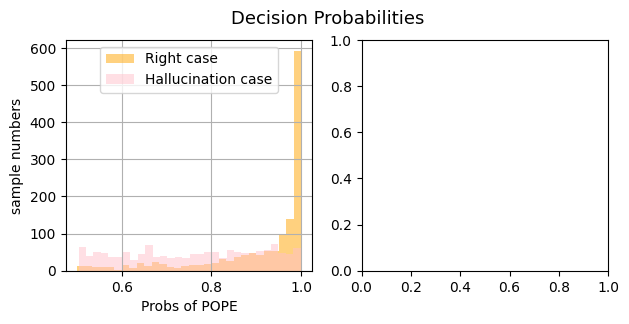

In [7]:
import matplotlib.pyplot as plt

# 创建一个2行1列的子图
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

fig.suptitle('Decision Probabilities', fontsize=13)
# 第一张图
axs[0].hist(equal_obj_right['decision_prob'], bins=30, alpha=0.5, label='Right case', color='orange')
axs[0].hist(obj_wrong['decision_prob'], bins=30, alpha=0.5, label='Hallucination case', color='pink')
axs[0].set_xlabel('Probs of POPE')
axs[0].set_ylabel('sample numbers')
# axs[0].set_title('Decision Confidence')
axs[0].legend(loc='upper center')
axs[0].grid(True)

# 第二张图
axs[1].hist(equal_rel_right['decision_prob'], bins=30, alpha=0.5, label='Right case', color='orange')
axs[1].hist(rel_wrong['decision_prob'], bins=30, alpha=0.5, label='Hallucination case', color='pink')
axs[1].set_xlabel('Probs of RLC')
# axs[1].set_ylabel('sample numbers')
# axs[1].set_title('Probs of Right and Wrong Rel Hallucination')
axs[1].legend(loc='upper right')
axs[1].grid(True)

# 调整布局
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2)#top 参数调整总标题距离图形的距离，值越小，距离越近  wspace 参数调整两个子图之间的水平间距
# 保存图像
plt.savefig('combined_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Object 物体幻觉对错的case的熵的分布

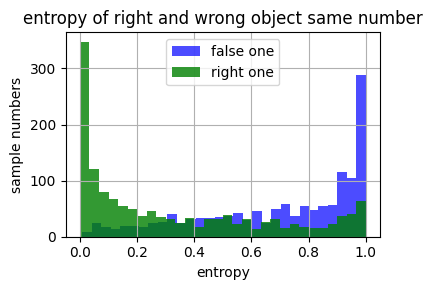

In [8]:
plt.figure(figsize=(4, 3))
plt.hist(obj_wrong['entropy'], bins=30, alpha=0.7, label='false one', color='blue')
plt.hist(equal_obj_right['entropy'], bins=30, alpha=0.8, label='right one', color='green')
plt.xlabel('entropy')
plt.ylabel('sample numbers')
plt.title('entropy of right and wrong object same number')
plt.legend(loc='upper center')
plt.grid(True)
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
obj_wrong.head()

,image_id,query_prompt,response,label,mllm_name,type,yes_prob,no_prob,entropy,decision_prob
1,COCO_val2014_000000310196,Is there a backpack in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.763484,0.236516,0.789199,0.763484
7,COCO_val2014_000000210789,Is there a car in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.997783,0.002217,0.022743,0.997783
11,COCO_val2014_000000210789,Is there a handbag in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.957912,0.042088,0.251784,0.957912
15,COCO_val2014_000000429109,Is there a motorcycle in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.936285,0.063715,0.342019,0.936285
17,COCO_val2014_000000429109,Is there a truck in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.845942,0.154058,0.619902,0.845942


In [15]:
obj_wrong_l_yes_p_no=obj_wrong[obj_wrong['label']=='yes']
obj_wrong_l_no_p_yes=obj_wrong[obj_wrong['label']=='no']
print('labe=yes的熵:')
print(obj_wrong_l_yes_p_no['entropy'].mean())
print('labe=no的熵:')
print(obj_wrong_l_no_p_yes['entropy'].mean())
# print(f'Length of wrong object case is {len(obj_wrong_l_yes_p_no)}')


labe=yes的熵:
0.6926926657419514
labe=no的熵:
0.698419374747964


In [16]:
obj_wrong_l_no_p_yes

,image_id,query_prompt,response,label,mllm_name,type,yes_prob,no_prob,entropy,decision_prob
1,COCO_val2014_000000310196,Is there a backpack in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.763484,0.236516,0.789199,0.763484
7,COCO_val2014_000000210789,Is there a car in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.997783,0.002217,0.022743,0.997783
11,COCO_val2014_000000210789,Is there a handbag in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.957912,0.042088,0.251784,0.957912
15,COCO_val2014_000000429109,Is there a motorcycle in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.936285,0.063715,0.342019,0.936285
17,COCO_val2014_000000429109,Is there a truck in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.845942,0.154058,0.619902,0.845942
...,...,...,...,...,...,...,...,...,...,...
8915,COCO_val2014_000000190788,Is there a tie in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.535098,0.464902,0.996443,0.535098
8967,COCO_val2014_000000122962,Is there a bottle in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.974435,0.025565,0.171639,0.974435
8983,COCO_val2014_000000121959,Is there a refrigerator in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.718594,0.281406,0.857359,0.718594
8987,COCO_val2014_000000121959,Is there a kite in the image?,yes,no,llava-v1.5-13b,object-YesNo,0.782663,0.217338,0.755276,0.782663


## Object绘制折线图

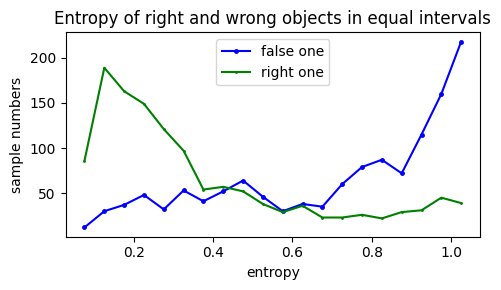

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 自动计算 entropy 属性的范围
min_entropy = min(obj_wrong['entropy'].min(), equal_obj_right['entropy'].min())
max_entropy = max(obj_wrong['entropy'].max(), equal_obj_right['entropy'].max())

# 定义区间，步长为 0.05
bins = np.arange(min_entropy, max_entropy + 0.05, 0.05)
labels = bins[:-1] + 0.05
# 计算每个区间内的样本数量
obj_wrong_binned = pd.cut(obj_wrong['entropy'], bins=bins,labels=labels,include_lowest=True).value_counts().sort_index()
equal_obj_right_binned = pd.cut(equal_obj_right['entropy'], bins=bins,labels=labels,include_lowest=True).value_counts().sort_index()

# 绘制折线图
plt.figure(figsize=(5, 3))
plt.plot(obj_wrong_binned.index, obj_wrong_binned.values, marker='.', markersize=5, label='false one', color='blue')
plt.plot(equal_obj_right_binned.index, equal_obj_right_binned.values, marker='.', markersize=2,label='right one', color='green')

plt.xlabel('entropy')
plt.ylabel('sample numbers')
plt.title('Entropy of right and wrong objects in equal intervals')
plt.legend(loc='upper center')
# plt.grid(True)
plt.tight_layout()
plt.savefig('test1.pdf', dpi=300, bbox_inches='tight')
plt.show()

## object绘制plotly图

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio



# 自动计算 entropy 属性的范围
min_entropy = min(obj_wrong['entropy'].min(), equal_obj_right['entropy'].min())
max_entropy = max(obj_wrong['entropy'].max(), equal_obj_right['entropy'].max())

# 定义区间，步长为 0.05
bins = np.arange(min_entropy, max_entropy + 0.05, 0.05)
labels = bins[:-1] + 0.05
# 计算每个区间内的样本数量
obj_wrong_binned = pd.cut(obj_wrong['entropy'], bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()
equal_obj_right_binned = pd.cut(equal_obj_right['entropy'], bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()

# 使用 Plotly 绘制折线图
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=obj_wrong_binned.index.astype(str),
    y=obj_wrong_binned.values,
    mode='lines+markers',
    name='false one',
    marker=dict(size=5),
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=equal_obj_right_binned.index.astype(str),
    y=equal_obj_right_binned.values,
    mode='lines+markers',
    name='right one',
    marker=dict(size=5),
    line=dict(color='green')
))

# 更新布局
fig.update_layout(
    title='Entropy of right and wrong objects in equal intervals',
    xaxis_title='entropy',
    yaxis_title='sample numbers',
    legend=dict(
        title='Legend',
        x=0.5,
        y=1,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='LightSteelBlue',
        bordercolor='Black',
        borderwidth=2
    ),
    template='plotly_white',
    autosize=False,
    width=700,
    height=500,
    margin=dict(
        l=50,  # left margin
        r=50,  # right margin
        b=50,  # bottom margin
        t=50   # top margin
    )
)

# 保存为 PDF
# pio.write_image(fig, 'test1.pdf')

# 显示图表
# fig.show()

# 关系数据

## 处理关系数据

In [3]:
rel_pd.iloc[0]

image_id                                                    1592267
query_prompt      Is the bus driver on bus in this photo? Please...
response                                                        Yes
label                                                           yes
mllm_name                                            llava-v1.5-13b
type                                                         Yes/No
yes_prob                                                   0.872263
no_prob                                                     0.12764
yes_layer_prob    {'0': 3.212690353393555e-05, '1': 3.1948089599...
no_layer_prob     {'0': 3.1888484954833984e-05, '1': 2.902746200...
Name: 0, dtype: object

In [4]:
rel_pd['entropy'] = rel_pd.apply(lambda row: entropy(row['yes_prob'], row['no_prob']), axis=1)
rel_pd['decision_prob']= rel_pd[['yes_prob', 'no_prob']].max(axis=1)
rel_pd['response']=rel_pd['response'].apply(filter_and_replace)
rel_right=rel_pd[rel_pd['response']==rel_pd['label']]
rel_wrong=rel_pd[rel_pd['response']!=rel_pd['label']]
print(f'Length of wrong relation case is {len(rel_wrong)}')
print(f'关系的总case为 {len(rel_pd)}')
print(f'关系中 正确case的数量为 {len(rel_right)}')

equal_rel_right = rel_right.sample(n=len(rel_wrong), random_state=1)
print(f'Length of equal rel_right is {len(equal_rel_right)}')
rel_pd.head()

Length of wrong relation case is 4064
关系的总case为 9740
关系中 正确case的数量为 5676
Length of equal rel_right is 4064


,image_id,query_prompt,response,label,mllm_name,type,yes_prob,no_prob,yes_layer_prob,no_layer_prob,entropy,decision_prob
0,1592267,Is the bus driver on bus in this photo? Please...,yes,yes,llava-v1.5-13b,Yes/No,0.872263,0.127640,"{'0': 3.212690353393555e-05, '1': 3.1948089599...","{'0': 3.1888484954833984e-05, '1': 2.902746200...",0.551051,0.872263
1,1592267,Is the bus driver between bus in this photo? p...,yes,no,llava-v1.5-13b,Yes/No,0.715257,0.284510,"{'0': 3.212690353393555e-05, '1': 3.1828880310...","{'0': 3.1888484954833984e-05, '1': 2.902746200...",0.861747,0.715257
2,2370275,Are the sandwich on plate in this photo? Pleas...,yes,yes,llava-v1.5-13b,Yes/No,0.969270,0.030674,"{'0': 3.212690353393555e-05, '1': 3.2484531402...","{'0': 3.1888484954833984e-05, '1': 2.938508987...",0.197840,0.969270
3,2370275,Is the sandwich covers plate in this photo? pl...,yes,no,llava-v1.5-13b,Yes/No,0.733791,0.265761,"{'0': 3.212690353393555e-05, '1': 3.2365322113...","{'0': 3.1888484954833984e-05, '1': 2.932548522...",0.835763,0.733791
4,2340467,Is the banner on building in this photo? Pleas...,yes,yes,llava-v1.5-13b,Yes/No,0.933386,0.066566,"{'0': 3.212690353393555e-05, '1': 3.2067298889...","{'0': 3.1888484954833984e-05, '1': 2.908706665...",0.353040,0.933386


## 关系概率分布图

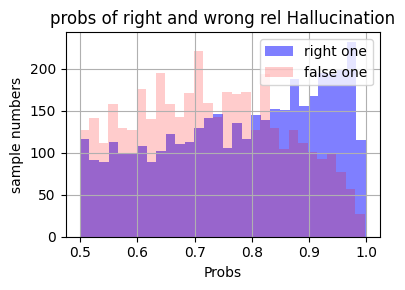

In [5]:
plt.figure(figsize=(4, 3))


plt.hist(equal_rel_right['decision_prob'], bins=30, alpha=0.5, label='right one', color='blue')
plt.hist(rel_wrong['decision_prob'], bins=30, alpha=0.2, label='false one', color='red')



plt.xlabel('Probs')
plt.ylabel('sample numbers')
plt.title('probs of right and wrong rel Hallucination')

plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 关系幻觉熵分布图

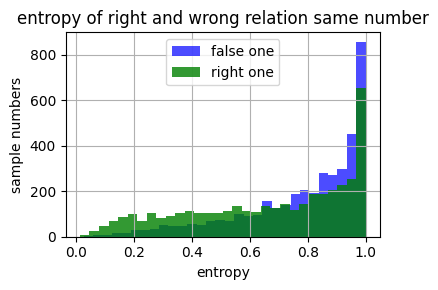

In [6]:
plt.figure(figsize=(4, 3))
plt.hist(rel_wrong['entropy'], bins=30, alpha=0.7, label='false one', color='blue')
plt.hist(equal_rel_right['entropy'], bins=30, alpha=0.8, label='right one', color='green')
plt.xlabel('entropy')
plt.ylabel('sample numbers')
plt.title('entropy of right and wrong relation same number')
plt.legend(loc='upper center')
plt.grid(True)
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
lena = len(rel_wrong[rel_wrong['entropy']>0.9])
lenb = len(rel_right[rel_right['entropy']>0.9])
print(f'entropy>0.9 wrong num= {lena}')
print(f'entropy>0.9 right num= {lenb}')

entropy>0.9 wrong num= 1638
entropy>0.9 right num= 1620


In [12]:
rel_pd['entropy'].describe()

count    9740.000000
mean        0.715435
std         0.259021
min         0.012561
25%         0.531921
50%         0.794080
75%         0.942342
max         1.000456
Name: entropy, dtype: float64

In [16]:
# rel_pd[rel_pd['entropy']==1.000456]
rel_pd.loc[rel_pd['entropy'].idxmax()]

image_id                                                    2355819
query_prompt      Is the women teaching ground in this photo? pl...
response                                                         no
label                                                            no
mllm_name                                            llava-v1.5-13b
type                                                         Yes/No
yes_prob                                                   0.495532
no_prob                                                    0.503336
yes_layer_prob    {'0': 3.212690353393555e-05, '1': 3.1650066375...
no_layer_prob     {'0': 3.1888484954833984e-05, '1': 2.866983413...
entropy                                                    1.000456
decision_prob                                              0.503336
Name: 7137, dtype: object

In [18]:
sorted_df = rel_pd.sort_values(by='entropy', ascending=False)
sorted_df.head()

,image_id,query_prompt,response,label,mllm_name,type,yes_prob,no_prob,yes_layer_prob,no_layer_prob,entropy,decision_prob
7137,2355819,Is the women teaching ground in this photo? pl...,no,no,llava-v1.5-13b,Yes/No,0.495532,0.503336,"{'0': 3.212690353393555e-05, '1': 3.1650066375...","{'0': 3.1888484954833984e-05, '1': 2.866983413...",1.000456,0.503336
5833,2389744,Is the wallpaper spelling room in this photo? ...,no,no,llava-v1.5-13b,Yes/No,0.491497,0.507099,"{'0': 3.212690353393555e-05, '1': 3.1888484954...","{'0': 3.1888484954833984e-05, '1': 2.896785736...",1.000444,0.507099
5501,2380918,Is the man smoking signal in this photo? pleas...,no,no,llava-v1.5-13b,Yes/No,0.495631,0.503436,"{'0': 3.212690353393555e-05, '1': 3.1709671020...","{'0': 3.1888484954833984e-05, '1': 2.878904342...",1.000369,0.503436
4757,2316929,Is the sun gripping player in this photo? plea...,no,no,llava-v1.5-13b,Yes/No,0.495647,0.503452,"{'0': 3.212690353393555e-05, '1': 3.1828880310...","{'0': 3.1888484954833984e-05, '1': 2.890825271...",1.000354,0.503452
4271,2355858,Is the goat at goat in this photo? please answ...,yes,no,llava-v1.5-13b,Yes/No,0.510859,0.487465,"{'0': 3.212690353393555e-05, '1': 3.1590461730...","{'0': 3.1888484954833984e-05, '1': 2.878904342...",1.000344,0.510859


In [28]:
sorted_df.iloc[-1200:-1000]['query_prompt']

3670    Is the sidewalk for pedestrian in this photo? ...
2159    Is the smoke alongside train in this photo? pl...
1400    Is the horse among sage brush in this photo? P...
3272    Is the building beyond palm tree in this photo...
1402    Is the giraffe among grass in this photo? Plea...
                              ...                        
4126    Are the bubbles within waves in this photo? Pl...
9186    Is the man gripping racket in this photo? Plea...
2551    Is the train alongside station in this photo? ...
1030    Is the body of snow in this photo? Please answ...
7632    Is the pole supporting clock in this photo? Pl...
Name: query_prompt, Length: 200, dtype: object

In [25]:
rel_pd.iloc[7136]

image_id                                                    2355819
query_prompt      Is the women waiting ground in this photo? Ple...
response                                                        yes
label                                                           yes
mllm_name                                            llava-v1.5-13b
type                                                         Yes/No
yes_prob                                                   0.685619
no_prob                                                    0.313899
yes_layer_prob    {'0': 3.212690353393555e-05, '1': 3.1769275665...
no_layer_prob     {'0': 3.1888484954833984e-05, '1': 2.872943878...
entropy                                                    0.898057
decision_prob                                              0.685619
Name: 7136, dtype: object

## 关系两个图一起绘制

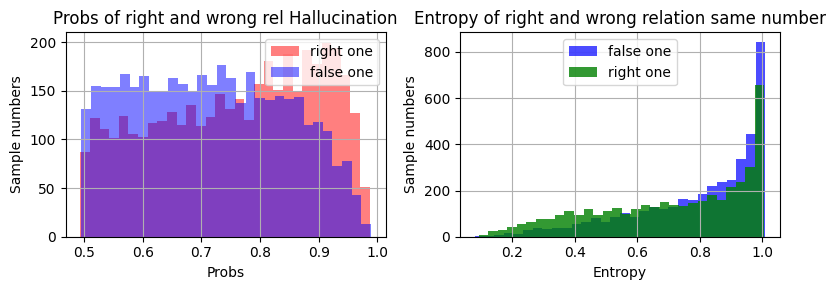

In [52]:
# 创建包含两个子图的图形
fig, axes = plt.subplots(1, 2, figsize=(8,3))

# 绘制第一个直方图
axes[0].hist(equal_rel_right['decision_prob'], bins=30, alpha=0.5, label='right one', color='red')
axes[0].hist(rel_wrong['decision_prob'], bins=30, alpha=0.5, label='false one', color='blue')
axes[0].set_xlabel('Probs')
axes[0].set_ylabel('Sample numbers')
axes[0].set_title('Probs of right and wrong rel Hallucination')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# 绘制第二个直方图
axes[1].hist(rel_wrong['entropy'], bins=30, alpha=0.7, label='false one', color='blue')
axes[1].hist(equal_rel_right['entropy'], bins=30, alpha=0.8, label='right one', color='green')
axes[1].set_xlabel('Entropy')
axes[1].set_ylabel('Sample numbers')
axes[1].set_title('Entropy of right and wrong relation same number')
axes[1].legend(loc='upper center')
axes[1].grid(True)

# 调整布局并保存图形
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()